# Test MonoDecoders: Sequence and Geometry
This notebook replicates the training logic from `learn.py` using the decoder in `mono_decoders.py` for amino acid and geometry prediction.

In [15]:
#use autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [17]:
# Imports
import torch
from torch_geometric.data import DataLoader
import numpy as np
from src import pdbgraph
from src import foldtree2_ecddcd as ft2
from src.mono_decoders import MultiMonoDecoder
import os
import tqdm
import random
import torch.nn.functional as F

In [18]:
# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data setup
datadir = '../../datasets/foldtree2/'
dataset_path = 'structs_traininffttest.h5'
converter = pdbgraph.PDB2PyG(aapropcsv='config/aaindex1.csv')
struct_dat = pdbgraph.StructureDataset(dataset_path)
train_loader = DataLoader(struct_dat, batch_size=5, shuffle=True, num_workers=4)
data_sample = next(iter(train_loader))

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
print('Data sample:', data_sample)

Data sample: HeteroDataBatch(
  identifier=[5],
  AA={
    x=[1323, 20],
    batch=[1323],
    ptr=[6],
  },
  R_true={
    x=[1323, 3, 3],
    batch=[1323],
    ptr=[6],
  },
  bondangles={
    x=[1323, 3],
    batch=[1323],
    ptr=[6],
  },
  coords={
    x=[1323, 3],
    batch=[1323],
    ptr=[6],
  },
  fourier1di={
    x=[1323, 80],
    batch=[1323],
    ptr=[6],
  },
  fourier1dr={
    x=[1323, 80],
    batch=[1323],
    ptr=[6],
  },
  fourier2di={
    x=[5, 1300],
    batch=[5],
    ptr=[6],
  },
  fourier2dr={
    x=[5, 1300],
    batch=[5],
    ptr=[6],
  },
  godnode={
    x=[5, 5],
    batch=[5],
    ptr=[6],
  },
  godnode4decoder={
    x=[5, 5],
    batch=[5],
    ptr=[6],
  },
  plddt={
    x=[1323, 1],
    batch=[1323],
    ptr=[6],
  },
  positions={
    x=[1323, 256],
    batch=[1323],
    ptr=[6],
  },
  res={
    x=[1323, 857],
    batch=[1323],
    ptr=[6],
  },
  t_true={
    x=[1323, 3],
    batch=[1323],
    ptr=[6],
  },
  (godnode4decoder, informs, res)={ edg

In [20]:
# Model setup

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
ndim = data_sample['res'].x.shape[1]
ndim_godnode = data_sample['godnode'].x.shape[1]
ndim_fft2i = data_sample['fourier2di'].x.shape[1]
ndim_fft2r = data_sample['fourier2dr'].x.shape[1]

num_embeddings = 40
embedding_dim = 20
hidden_size = 200

encoder = ft2.mk1_Encoder(
	in_channels=ndim,
	hidden_channels=[hidden_size*2, hidden_size*2],
	out_channels=embedding_dim,
	metadata={'edge_types': [('res','contactPoints','res')]},
	num_embeddings=num_embeddings,
	commitment_cost=0.9,
	edge_dim=1,
	encoder_hidden=hidden_size,
	EMA=True,
	nheads=5,
	dropout_p=0.01,
	reset_codes=False,
	flavor='transformer',
	fftin=True
)


print(encoder)
encoder = encoder.to(device)

# MultiMonoDecoder for sequence and geometry
mono_configs = {
	'sequence_transformer': {
		'in_channels': {'res': embedding_dim},
		'xdim': 20,
		'concat_positions': True,
		'hidden_channels': {('res','backbone','res'): [hidden_size]*3 , ('res','backbonerev','res'): [hidden_size]*3},
		'layers': 2,
		'AAdecoder_hidden': [hidden_size, hidden_size, hidden_size//2],
		'amino_mapper': converter.aaindex,
		'flavor': 'sage',
		'nheads': 1,
		'dropout': 0.005,
		'normalize': True,
		'residual': False
	},
	
	'contacts': {
		'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23 ,  'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},
		'concat_positions': True,
		'hidden_channels': {('res','backbone','res'): [hidden_size]*4, ('res','backbonerev','res'): [hidden_size]*4, ('res','informs','godnode4decoder'): [hidden_size]*4 , ('godnode4decoder','informs','res'): [hidden_size]*4},
		'layers': 3,
		'FFT2decoder_hidden': [hidden_size, hidden_size, hidden_size],
		'contactdecoder_hidden': [hidden_size, hidden_size//2],
		'nheads': 1,
		'Xdecoder_hidden': [hidden_size, hidden_size,  hidden_size ],
		'metadata': converter.metadata,
		'flavor': 'mfconv',
		'dropout': 0.005,
		'output_fft': False,
        'output_rt':False,
		'normalize': True,
		'residual': False,
		'contact_mlp': True

	}
}
decoder = MultiMonoDecoder( configs=mono_configs)
encoder = encoder.to(device)
decoder = decoder.to(device)

print(decoder)

Seed set to 42
Seed set to 42
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Seed set to 42


mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): TransformerConv(400, 400, heads=5)
    )
  )
  (norms): ModuleList(
    (0): GraphNorm(400)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (jk): JumpingKnowledge(cat)
  (ffin): Sequential(
    (0): Linear(in_features=1017, out_features=800, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=800, out_features=400, bias=True)
    (3): GELU(approximate='none')
    (4): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
  )
  (lin): Sequential(
    (0): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): GELU(approximate='none')
    (5): DynamicTanh(normalized_shape=200, alpha_in

In [25]:
# Training loop (demo, similar to learn.py)
import time
from collections import defaultdict

num_epochs = 50  # For demonstration, keep small
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

edgeweight = 0.01
xweight = .1
fft2weight = 0.01
vqweight = 0.0001
clip_grad = True
encoder.device = device
encoder.train()
decoder.train()


MultiMonoDecoder(
  (decoders): ModuleDict(
    (sequence_transformer): Transformer_AA_Decoder(
      (input_proj): Sequential(
        (0): DynamicTanh(normalized_shape=276, alpha_init_value=0.5, channels_last=True)
        (1): Linear(in_features=276, out_features=200, bias=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0.005, inplace=False)
        (4): Linear(in_features=200, out_features=200, bias=True)
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
            )
            (linear1): Linear(in_features=200, out_features=2048, bias=True)
            (dropout): Dropout(p=0.005, inplace=False)
            (linear2): Linear(in_features=2048, out_features=200, bias=True)
            (norm1): LayerNorm((200,), eps=1e-05, elementwise_a

In [26]:
#get one sample from the dataloader
train_loader = DataLoader(struct_dat, batch_size=1, shuffle=True, num_workers=4)
data_sample = next(iter(train_loader))
data = data_sample.to(device)
optimizer.zero_grad()
z, vqloss = encoder(data , debug = True)
print('Encoded z shape:', z.shape)

torch.Size([421, 857]) x_dict[res] shape
z_quantized shape: torch.Size([421, 20])
vq_loss: tensor(0.9753, device='cuda:1', grad_fn=<SubBackward0>)
x shape: torch.Size([421, 20])
x_dict keys: dict_keys(['AA', 'R_true', 'bondangles', 'coords', 'fourier1di', 'fourier1dr', 'fourier2di', 'fourier2dr', 'godnode', 'godnode4decoder', 'plddt', 'positions', 'res', 't_true'])
edge_index_dict keys: dict_keys([('godnode4decoder', 'informs', 'res'), ('godnode', 'informs', 'res'), ('res', 'backbone', 'res'), ('res', 'backbonerev', 'res'), ('res', 'contactPoints', 'res'), ('res', 'hbond', 'res'), ('res', 'informs', 'godnode'), ('res', 'informs', 'godnode4decoder'), ('res', 'window', 'res'), ('res', 'windowrev', 'res')])
Encoded z shape: torch.Size([421, 20])


In [27]:
from Bio import PDB
from Bio.PDB import PDBParser
from src.AFDB_tools import 	grab_struct

def getCAatoms(pdb_file):
	parser = PDBParser(QUIET=True)
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	return ca_atoms

In [28]:
#get aa and contacts

from torch_geometric.data import DataLoader , HeteroData
from scipy import sparse
from matplotlib import pyplot as plt

def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	print(ords)
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	print( 'positional encoding shape:', positional_encoding.shape )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	print( data['res'].x.shape )
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	out = decoder( data , allpairs ) 

	recon_x = out['aa'] if 'aa' in out else None
	edge_probs = out['edge_probs'] if 'edge_probs' in out else None

	print( edge_probs.shape)
	try:
		amino_map = decoder.decoders['sequence'].amino_acid_indices
	except:
		amino_map = decoder.decoders['sequence_transformer'].amino_acid_indices
		print('Using amino_acid_indices_dict instead of amino_acid_indices')
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

Epoch 0:   0%|                                                                 | 0/500 [00:00<?, ?it/s]/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 0: 100%|███████████████████████████████████████████████████████| 500/500 [03:26<00:00,  2.42it/s]


Epoch 0: AA Loss: 2.9445, Edge Loss: 1.4129, VQ Loss: 0.9750 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([421, 20])
Encoded zdiscrete shape: torch.Size([421])
tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 2

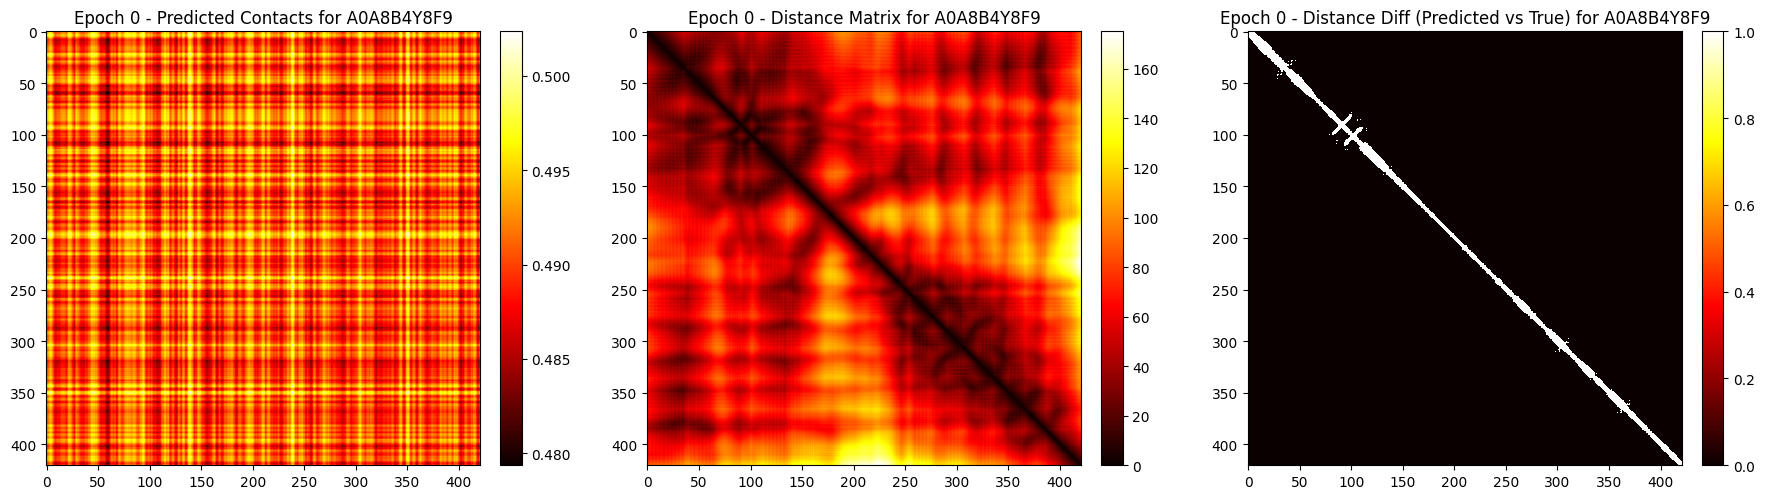

Epoch 1:   0%|                                                                 | 0/500 [00:00<?, ?it/s]/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 1: 100%|███████████████████████████████████████████████████████| 500/500 [03:38<00:00,  2.29it/s]


Epoch 1: AA Loss: 2.8893, Edge Loss: 1.3891, VQ Loss: -0.4085 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([421, 20])
Encoded zdiscrete shape: torch.Size([421])
tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 28, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 28, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 28, 28, 28, 28, 28, 28, 37, 28, 28, 37, 37, 28, 37, 37, 37, 37,
        37, 37, 28, 28, 37, 28, 28, 28, 28, 21, 21, 21, 21, 21, 21, 28, 28, 28,
        28, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 28, 28, 21, 21, 21, 21, 21, 28, 21, 21, 28, 28,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        28, 28, 28, 28, 28, 28, 28, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 

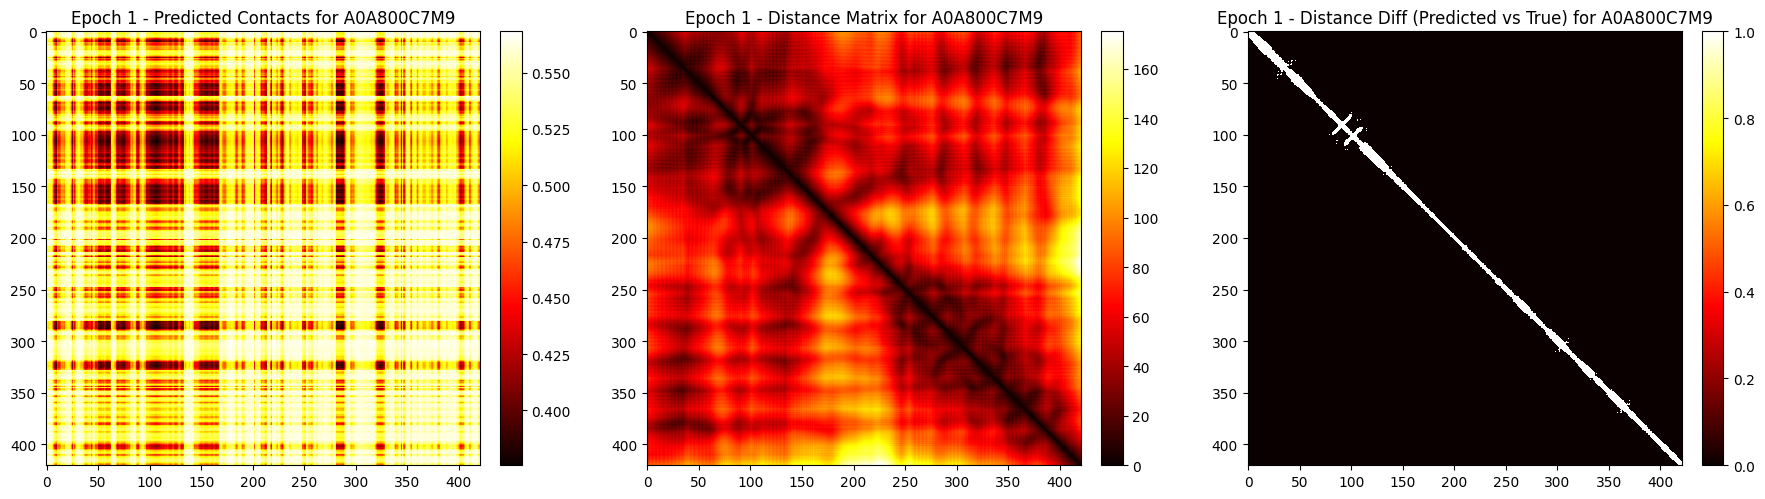

Epoch 2:   0%|                                                                 | 0/500 [00:00<?, ?it/s]/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 2: 100%|███████████████████████████████████████████████████████| 500/500 [03:41<00:00,  2.26it/s]


Epoch 2: AA Loss: 2.8778, Edge Loss: 1.2809, VQ Loss: -0.9410 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([421, 20])
Encoded zdiscrete shape: torch.Size([421])
tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 36, 36, 26, 28, 26, 26, 28, 28, 28, 28, 37, 28, 28, 28, 37, 26, 36,
        26, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 26, 28, 28,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 28, 28, 37, 28, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 28, 28, 36, 36, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 

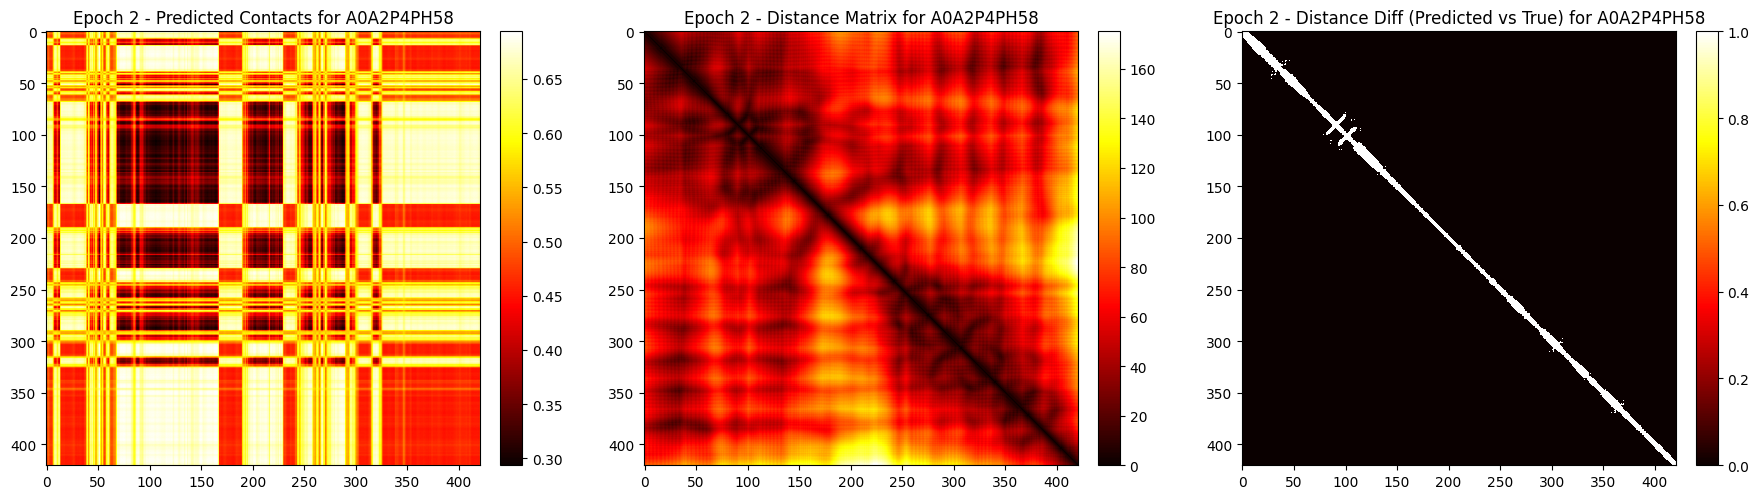

Epoch 3:   0%|                                                                 | 0/500 [00:00<?, ?it/s]/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 3: 100%|███████████████████████████████████████████████████████| 500/500 [03:46<00:00,  2.21it/s]


Epoch 3: AA Loss: 2.8737, Edge Loss: 1.1237, VQ Loss: -1.3433 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([421, 20])
Encoded zdiscrete shape: torch.Size([421])
tensor([21, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 21, 36, 36, 21, 21, 21,
        21, 36, 36, 36, 26, 26, 26, 26, 17, 17, 17,  7,  7,  7,  7, 28, 28, 28,
         7,  7,  7,  7,  7,  7,  7,  7,  7, 17,  7,  7, 28, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 28, 28, 28, 17, 26, 36, 36, 21, 21, 21, 21, 21,
        21, 21, 36, 36, 36, 36, 26, 

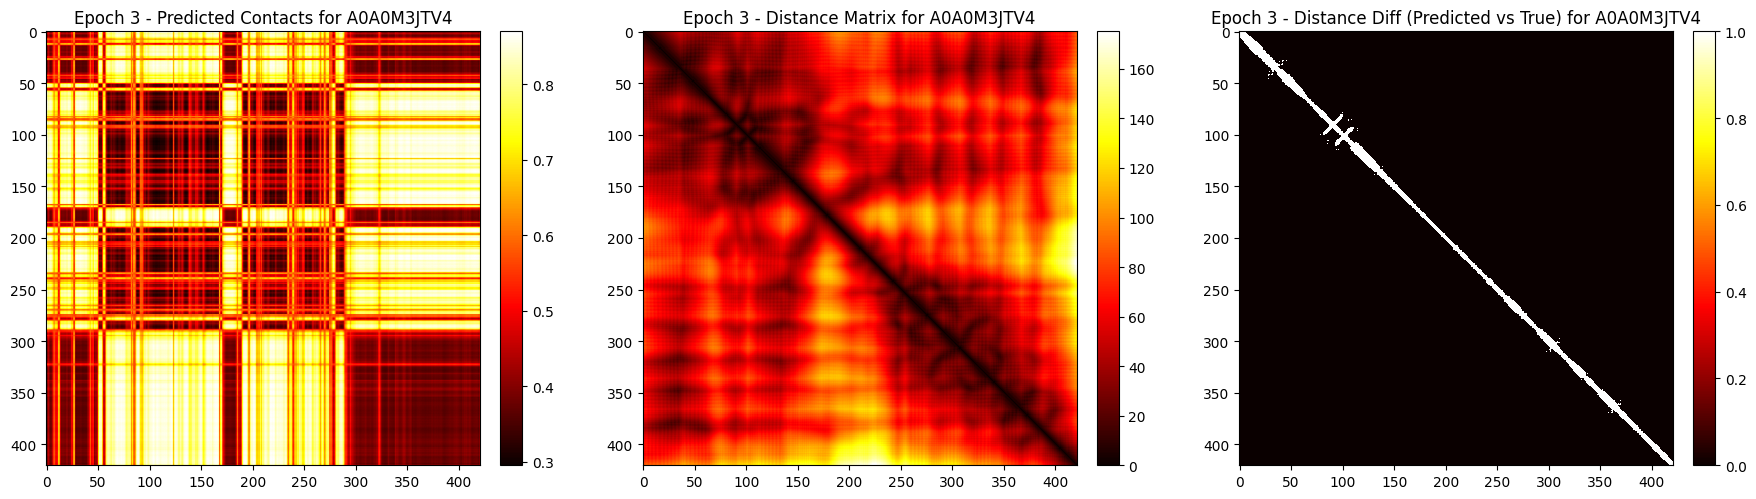

Epoch 4:   0%|                                                                 | 0/500 [00:00<?, ?it/s]/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 4: 100%|███████████████████████████████████████████████████████| 500/500 [03:34<00:00,  2.34it/s]


Epoch 4: AA Loss: 2.8715, Edge Loss: 1.0306, VQ Loss: -1.6318 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([421, 20])
Encoded zdiscrete shape: torch.Size([421])
tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 17, 17, 26, 26, 26, 26, 17,  0,  7,  7,  7,  7,  7,  7,  7,  7,  1,
         0,  0, 17, 17, 17, 17, 26, 26, 26, 26, 26, 26, 26, 26, 26, 17,  1,  0,
         7,  7,  7,  7, 28, 28, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 28, 28,  7,  7,  0,  1, 17, 17, 17,  1,  0,  7, 28, 28, 28,
        28, 28, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 28, 28, 28,
        28, 28, 28, 28, 28,  7,  7,  1, 26, 36, 36, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 36, 36, 26, 26, 

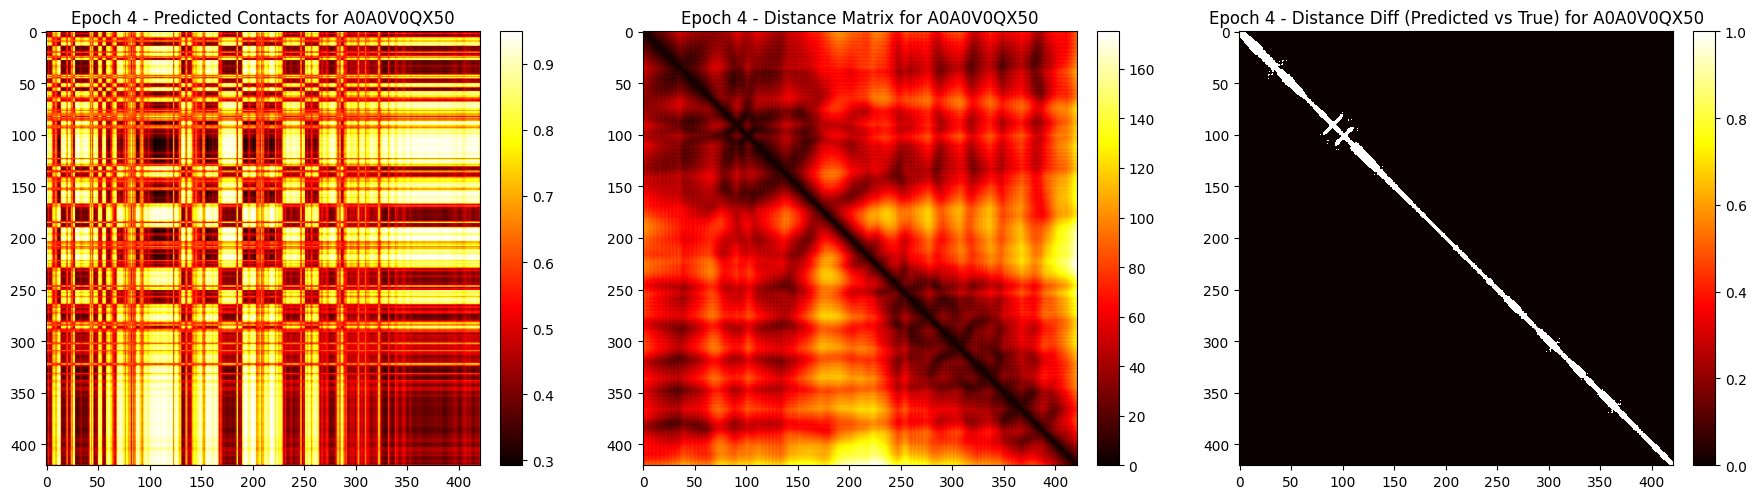

Epoch 5:   0%|                                                                 | 0/500 [00:00<?, ?it/s]/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 5: 100%|███████████████████████████████████████████████████████| 500/500 [03:36<00:00,  2.31it/s]


Epoch 5: AA Loss: 2.8695, Edge Loss: 0.9928, VQ Loss: -1.7334 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([421, 20])
Encoded zdiscrete shape: torch.Size([421])
tensor([21, 21, 21, 21, 21, 21, 36, 36, 36, 36, 17, 36, 36,  2, 17, 36, 26,  1,
        17, 17, 17,  2, 17, 17, 17,  2, 26, 26, 26, 26, 36, 26, 17, 26, 36, 26,
        26, 17,  2,  1,  7,  7,  7, 28, 28, 28, 28, 37, 37, 28, 28, 28, 28, 28,
        28, 28,  7,  7, 28,  7,  7,  7,  7,  0,  0,  0,  0,  7, 28, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        28, 28, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 28, 28,  7, 28, 28, 28, 28, 28, 28, 37, 28,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 28,  7,  2, 36, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 

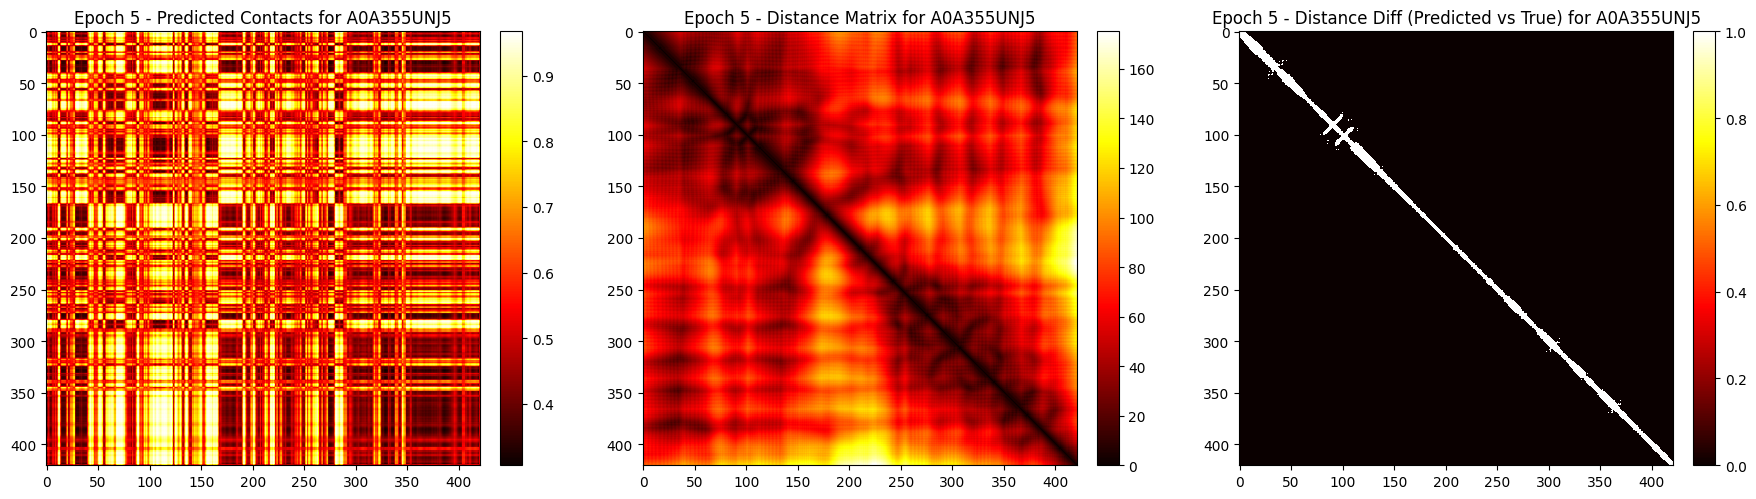

Epoch 6:   0%|                                                                 | 0/500 [00:00<?, ?it/s]/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 6:  95%|████████████████████████████████████████████████████   | 473/500 [03:34<00:12,  2.20it/s]


KeyboardInterrupt: 

In [29]:
train_loader = DataLoader(struct_dat, batch_size=10, shuffle=True, num_workers=4)
encoder.train()
decoder.train()
from losses.losses import recon_loss_diag , aa_reconstruction_loss
for epoch in range(num_epochs):
	total_loss_x = 0
	total_loss_edge = 0
	total_vq = 0
	total_loss_fft2 = 0
	for data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch}"):
		data = data.to(device)
		optimizer.zero_grad()
		z, vqloss = encoder(data)
		data['res'].x = z
		# For demonstration, only sequence and contacts tasks
		out = decoder(data, None)
		recon_x = out['aa'] if isinstance(out, dict) and 'aa' in out else out[0] if isinstance(out, (list, tuple)) else None
		fft2_x = out['fft2pred'] if isinstance(out, dict) and 'fft2pred' in out else out[1] if isinstance(out, (list, tuple)) else None
		# Edge loss: use contactPoints if available
		edge_index = data.edge_index_dict['res', 'contactPoints', 'res'] if hasattr(data, 'edge_index_dict') and ('res', 'contactPoints', 'res') in data.edge_index_dict else None
		if edge_index is not None:
			edgeloss, _ = recon_loss_diag(data, edge_index, decoder, plddt=False, offdiag=False , key = 'edge_probs')
		else:
			edgeloss = torch.tensor(0.0, device=device)
		xloss = aa_reconstruction_loss(data['AA'].x, recon_x)
		if fft2_x is not None:
			fft2loss = F.smooth_l1_loss(torch.cat( [ data['fourier2dr'].x ,data['fourier2di'].x ] ,axis = 1 ) , fft2_x )
		else:
			fft2loss = torch.tensor(0.0, device=device)
		loss = xweight * xloss + edgeweight * edgeloss + vqweight * vqloss + fft2loss* fft2weight

		loss.backward()
		if clip_grad:
			torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
			torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
		optimizer.step()
		total_loss_x += xloss.item()
		total_loss_edge += edgeloss.item()
		total_loss_fft2 += fft2loss.item()
		total_vq += vqloss.item() if isinstance(vqloss, torch.Tensor) else float(vqloss)
	scheduler.step(total_loss_x)
	print(f"Epoch {epoch}: AA Loss: {total_loss_x/len(train_loader):.4f}, Edge Loss: {total_loss_edge/len(train_loader):.4f}, VQ Loss: {total_vq/len(train_loader):.4f} , FFT2 Loss: {total_loss_fft2/len(train_loader):.4f}")

	encoder.eval()
	decoder.eval()
	
	# predict all vs all contacts for the last sample
	data_sample = data_sample.to(device)
	z, vqloss = encoder(data_sample)
	print('Encoded z shape:', z.shape)
	ords = encoder.vector_quantizer.discretize_z(z.detach())
	zdiscrete = ords[0].detach()
	print('Encoded zdiscrete shape:', zdiscrete.shape)
	
	aastr, edge_probs = decoder_reconstruction2aa( zdiscrete , device, verbose=True)
	#show the distance matrix
	grab_struct(str(data_sample.identifier[0]) , structfolder='tmp/')
	#find the total number of residues
	ca_atoms = getCAatoms( 'tmp/' + str(data_sample.identifier[0]) + '.pdb')
	dist_mat = np.zeros((len(ca_atoms), len(ca_atoms)))
	
	for i, res1 in enumerate(ca_atoms):
		for j, res2 in enumerate(ca_atoms):
			if i < j:
				dist_mat[i, j] = np.linalg.norm(res1.coord - res2.coord)
	dist_mat += dist_mat.T  # Make it symmetric
	np.fill_diagonal(dist_mat, 0)
	
	ndistmat = dist_mat.copy()
	ndistmat[dist_mat>10 ] = 0
	ndistmat[dist_mat<=10 ] = 1

	fig, axs = plt.subplots(1, 3, figsize=(18, 5))

	im0 = axs[0].imshow(1 - edge_probs.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
	axs[0].set_title(f"Epoch {epoch} - Predicted Contacts for {data.identifier[0]}")
	fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

	im1 = axs[1].imshow(dist_mat, cmap='hot', interpolation='nearest')
	axs[1].set_title(f"Epoch {epoch} - Distance Matrix for {data.identifier[0]}")
	fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

	im2 = axs[2].imshow(ndistmat, cmap='hot', interpolation='nearest')
	axs[2].set_title(f"Epoch {epoch} - Distance Diff (Predicted vs True) for {data.identifier[0]}")
	fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

	plt.tight_layout()
	plt.show()

	encoder.train()
	decoder.train()



In [27]:
#save the model
import pickle
if not os.path.exists('models/'):
	os.makedirs('models/')
with open('models/testdebug.pkl', 'wb') as f:
	pickle.dump([encoder,decoder], f)

#save state
import torch
torch.save(encoder.state_dict(), 'models/encoder_testdebug.pth')
torch.save(decoder.state_dict(), 'models/decoder_testdebug.pth')

print("Training complete and models saved.")

Training complete and models saved.


In [ ]:
print(encoded_df.head())
#grab the pdbs and get the total number of residues
#ensure encoder produces fastas with the same residues as the pdbs
pdbs = []
for identifier in encoded_df.index:
	pdbs.append( str(identifier) + '.pdb' )
encoded_df['pdb'] = pdbs
for i in range(len(encoded_df)):
	identifier = encoded_df.index[i]
	pdb_file = 'tmp/' + identifier + '.pdb'
	if not os.path.exists(pdb_file):
		grab_struct(str(identifier), structfolder='tmp/')
	ca_atoms = getCAatoms(pdb_file)
	total_residues = sum(len(atoms) for atoms in ca_atoms.values())
	encoded_df.at[identifier, 'total_residues'] = total_residues
encoded_df['delta'] = encoded_df['length_ord'] - encoded_df['total_residues']
assert (encoded_df['delta'] == 0).all(), "Mismatch between sequence length and total residues in PDB files"
assert (encoded_df['length_ord'] == encoded_df['length_hex']).all(), "Mismatch between ord and hex lengths"
assert (encoded_df['length_ord'] == encoded_df['length_seq']).all(), "Mismatch between ord and sequence lengths"
assert (encoded_df['length_hex'] == encoded_df['length_seq']).all(), "Mismatch between hex and sequence lengths"
print("All checks passed. Sequence lengths match PDB total residues and ord/hex lengths.")
print("Encoded sequences DataFrame:")
encoded_df.to_csv('encoded_sequences.csv')

NameError: name 'encoded_df' is not defined